### Аналитика данных

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [102]:
train = pd.read_excel("data/excel/train.xlsx")

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      400 non-null    datetime64[ns]
 1   Price   400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


здесь видно, что в train не так много разнообразия данных, но данные полные

In [104]:
df = train.copy()

df['year'] = train['dt'].dt.year              # Год
df['month'] = train['dt'].dt.month            # Месяц (1-12)
df['quarter'] = train['dt'].dt.quarter        # Квартал (1-4)
df['day_of_week'] = train['dt'].dt.dayofweek  # День недели (0-6, 0=понедельник)
df['day_of_month'] = train['dt'].dt.day       # День месяца

In [105]:
df

,dt,Price,year,month,quarter,day_of_week,day_of_month
0,2015-01-05,32900,2015,1,1,0,5
1,2015-01-12,32500,2015,1,1,0,12
2,2015-01-19,32000,2015,1,1,0,19
3,2015-01-26,30700,2015,1,1,0,26
4,2015-02-02,30300,2015,2,1,0,2
...,...,...,...,...,...,...,...
395,2022-08-01,47500,2022,8,3,0,1
396,2022-08-08,49000,2022,8,3,0,8
397,2022-08-15,47500,2022,8,3,0,15
398,2022-08-22,46500,2022,8,3,0,22


In [106]:
df.describe()

,dt,Price,year,month,quarter,day_of_week,day_of_month
count,400,400.000000,400.000000,400.000000,400.000000,400.0,400.000000
mean,2018-11-01 12:00:00,39229.475000,2018.350000,6.347500,2.455000,0.0,15.737500
min,2015-01-05 00:00:00,21000.000000,2015.000000,1.000000,1.000000,0.0,1.000000
25%,2016-12-03 06:00:00,31075.000000,2016.000000,3.000000,1.000000,0.0,8.000000
50%,2018-11-01 12:00:00,35450.000000,2018.000000,6.000000,2.000000,0.0,16.000000
75%,2020-09-29 18:00:00,42000.000000,2020.000000,9.000000,3.000000,0.0,23.000000
max,2022-08-29 00:00:00,79000.000000,2022.000000,12.000000,4.000000,0.0,31.000000
std,NaN,13407.979668,2.220321,3.408929,1.107267,0.0,8.808096


In [107]:
df = df.set_index(['dt'])
df.sort_index(inplace=True)
df.head()

,Price,year,month,quarter,day_of_week,day_of_month
dt,,,,,,
2015-01-05,32900,2015,1,1,0,5
2015-01-12,32500,2015,1,1,0,12
2015-01-19,32000,2015,1,1,0,19
2015-01-26,30700,2015,1,1,0,26
2015-02-02,30300,2015,2,1,0,2


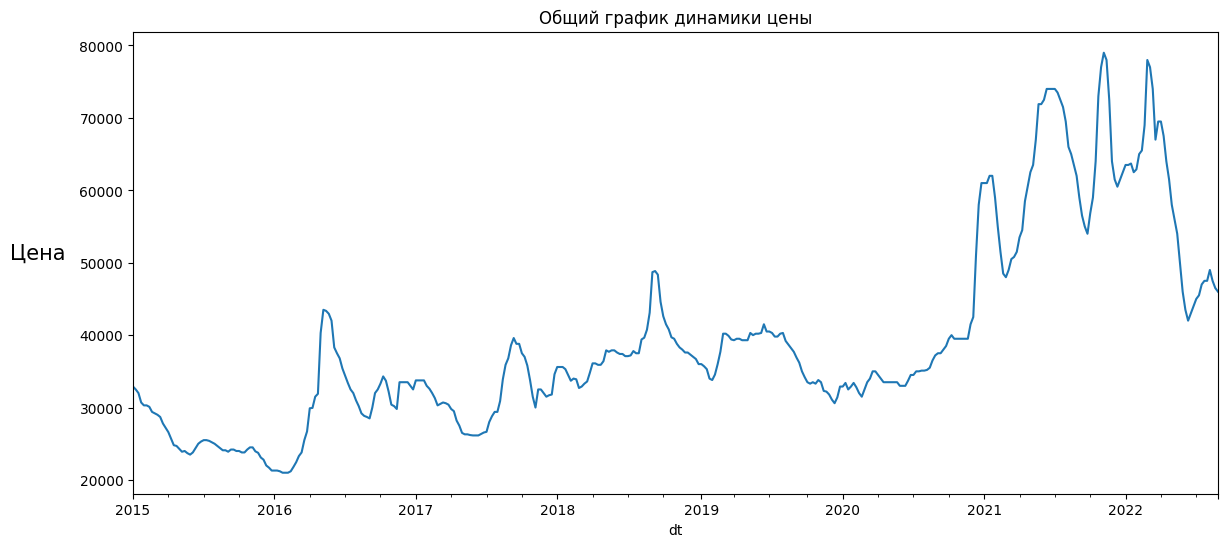

In [108]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Общий график динамики цены')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
df['Price'].plot();

Стационарность

In [109]:
def check_stationary(df):
    p_value = adfuller(df['Price'])[1]
    print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')
    if p_value > 0.05:
        print(f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной')
    else:
        print(f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным')

In [110]:
check_stationary(df)

Полученный уровень значимости (p-value): 0.32.
0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной


#### скользящая точка, логарифмирование и дифференцирование

In [111]:
window = 12  # Например, 12 для месячных данных

df_roll = df.copy()
df_roll['rolling_std'] = df_roll['Price'].rolling(window=window).std()

# Нормализуем данные
df_roll['normalized_price'] = df_roll['Price'] / df_roll['rolling_std']

# Затем логарифмируем и дифференцируем
df_roll['log_normalized_price'] = np.log(df_roll['normalized_price'] + 1e-10)  # Добавляем константу, чтобы избежать нулей
df_roll['Price'] = df_roll['log_normalized_price'].diff().dropna()

df_roll = df_roll.dropna()
df_roll

,Price,year,month,quarter,day_of_week,day_of_month,rolling_std,normalized_price,log_normalized_price
dt,,,,,,,,,
2015-03-30,-0.012110,2015,3,1,0,30,1556.413905,17.476071,2.860833
2015-04-06,-0.015806,2015,4,2,0,6,1546.329966,17.202021,2.845027
2015-04-13,-0.071902,2015,4,2,0,13,1605.388653,16.008585,2.773125
2015-04-20,-0.172149,2015,4,2,0,20,1840.186914,13.476892,2.600977
2015-04-27,-0.077325,2015,4,2,0,27,1980.109425,12.474058,2.523651
...,...,...,...,...,...,...,...,...,...
2022-08-01,0.271592,2022,8,3,0,1,3320.049288,14.307017,2.660750
2022-08-08,0.330165,2022,8,3,0,8,2461.829820,19.903894,2.990915
2022-08-15,0.097365,2022,8,3,0,15,2165.063509,21.939310,3.088280


In [112]:
check_stationary(df_roll)

Полученный уровень значимости (p-value): 0.0.
0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным


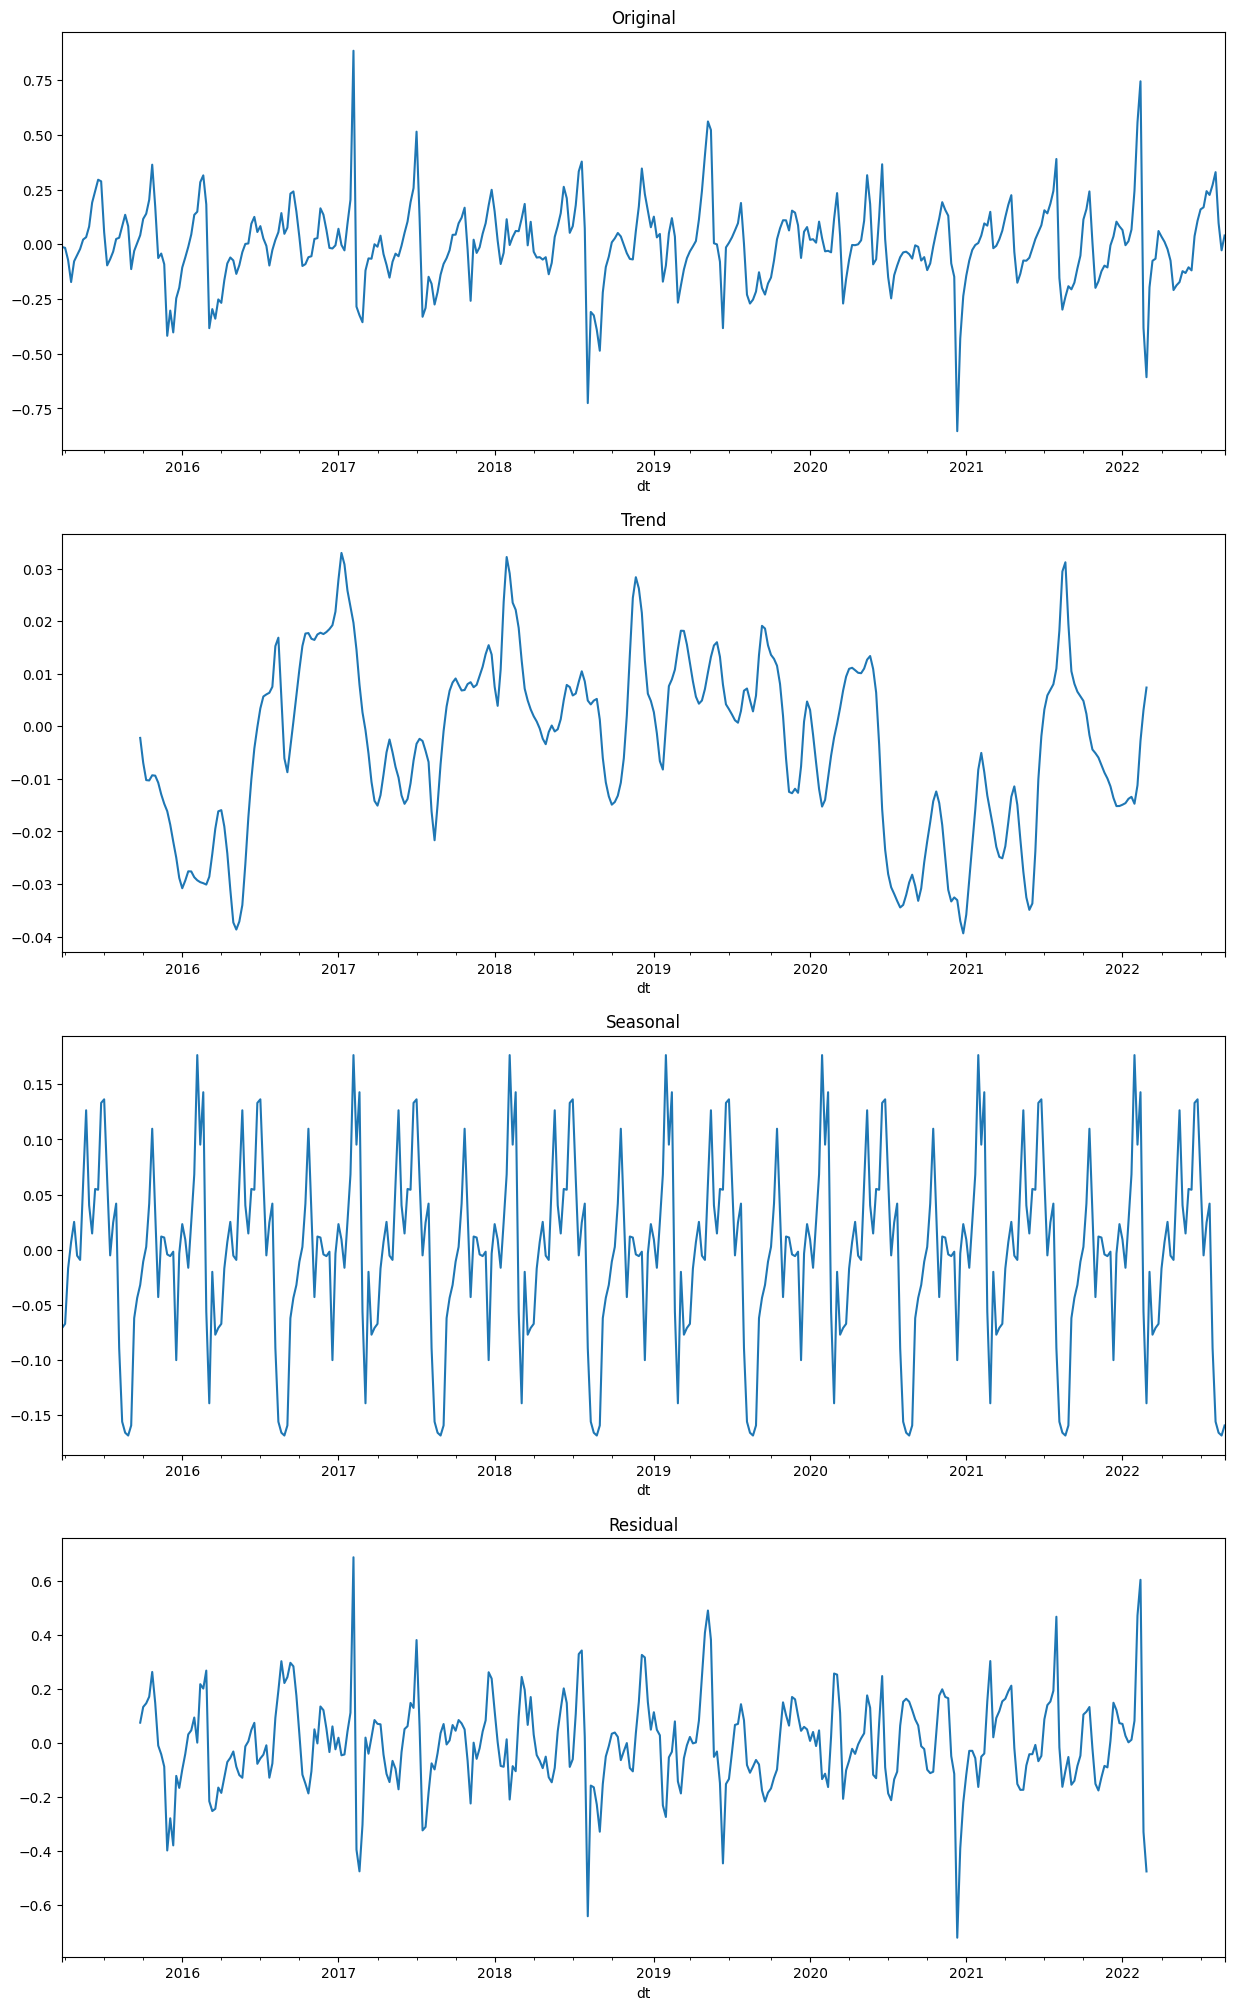

In [113]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
decompose = seasonal_decompose(df_roll['Price']) 

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [114]:
df_roll.to_csv("to-modal.csv", index=True)